<a href="https://colab.research.google.com/github/PedroCtba/ProjetoDataScience_Previssao_Churn/blob/main/Previs%C3%A3o_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aumente o Faturamento da Empresa com Previsão de Churn

Nesse notebook trago a minha resolução do desafio do blog "Seja Um Data Scientist". Aqui está a parte mais técnica, com os códigos utilizados e o explicativo dos processos até a solução final. A explicação mais simples e "amigável" está no READMDE do github. Também peço que possam me auxiliar e corrigir sob possíveis erros, como foi meu primeiro projeto entendo que possa ter processos adicionais para implementar.

## O problema:

A empresa está perdendo muitos clientes ultimamente

## A solução em ciência de dados:

Criar uma IA que possa fazer o processo de prever a saída dos clientes e criar uma lista com os possíveis "canceladores" para que a empresa possa alinhar uma medida para esses clientes, evitando que eles saiam

# Importação de bibliotecas

Região onde importo as bibliotecas para uso

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from warnings import simplefilter # tirar os warnings
simplefilter(action='ignore', category=FutureWarning)


from sklearn.preprocessing import StandardScaler # escala
from sklearn.preprocessing import LabelEncoder # string --> Números
from sklearn.preprocessing import OneHotEncoder # escalar o labelencoder
from sklearn.compose import ColumnTransformer # criar mais colunas pra ecodar as strings
from sklearn.model_selection import train_test_split # dividir treino e teste
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # deixar classes equilibradas
import pickle as pkl # salvar

# arvore
from sklearn import tree
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_iris

# SVM
from sklearn.svm import SVC

# rede neural
from sklearn.neural_network import MLPClassifier

# tunning
from sklearn.model_selection import GridSearchCV
import numpy as np

# validação cruzada
from sklearn.model_selection import cross_val_score, KFold

# testes de hipótese
from scipy.stats import shapiro
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison

# Checar Tipagem & Nulos

Checar se os tipos dos dados estão corretos e se o DataFrame não tem dados nulos para serem preenchidos

In [ ]:
df = pd.read_csv('churn.csv')

In [ ]:
df.head()

# olhar inicial

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe()

# resumo aparentemente normal. Máximos e mínimos aceitáveis

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
df.info()

# o tipo do customer está como int, porém por se tratar de um ID ele é uma string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df['CustomerId'] = df['CustomerId'].apply(str)

In [ ]:
df.isnull().sum()

# sem nulos!

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# Ver o quão balanceadas estão as classes

Bases desbalanceadas não são um problema por si só, porém o fato de serem assim pode gerar percepções erradas sobre a  acurácia do modelo, portanto é necessário antes da EDA e principalmente antes de rodar qualquer modelo de ML saber como está o balanceamento da sua classe para prever, assim os insights e leituras sobre a precisão dos modelos serão melhores

Quantia de clientes perdidos:2037 
Quantia de clientes ainda ativos: 7963

Portanto, 20,37% da base de dados é da classe "Exited"


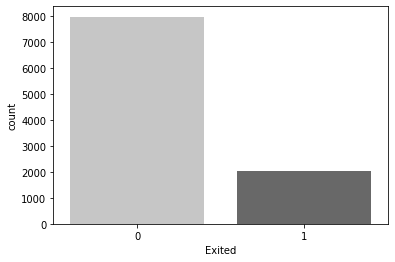

In [ ]:
sns.countplot(data=df, x='Exited', palette='Greys');

# base desbalanceada, temos muito mais gente na classe 0.

quantia_exited = 0
quantia_não_exited = 0

for i in df['Exited']:
    if i == 1:
        quantia_exited += 1
    if i == 0:
        quantia_não_exited += 1
        

          
print(f'Quantia de clientes perdidos:{quantia_exited} \nQuantia de clientes ainda ativos: {quantia_não_exited}')
print('\nPortanto, 20,37% da base de dados é da classe "Exited"')

As classes estão bem desbalanceadas e isso necessitará de ajuste antes de treinar o modelo futuramente, é melhor estudar a correlação entre variáveis com as classes 1 e 0 em igualdade

# Checagem de outliers

Aqui checo por valores discrepantes que possam ser erros nos registros ou informações valiosas sobre a classe que estou tentando prever

In [ ]:
sns.set(rc={'figure.figsize':(16.0, 6.0)})

In [ ]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

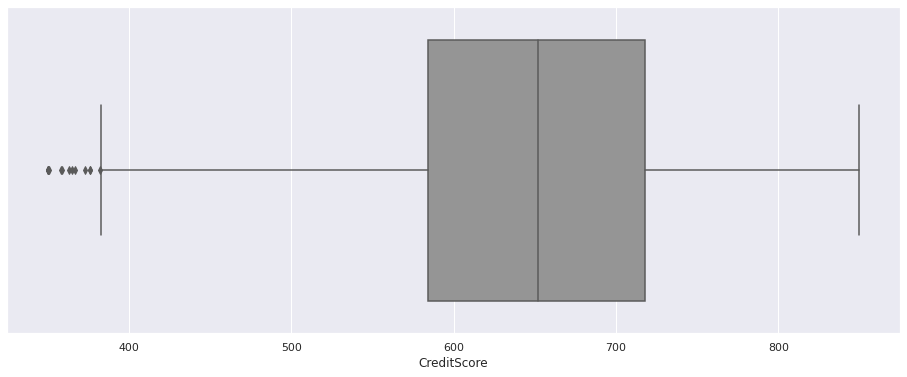

In [ ]:
sns.boxplot(data=df, x='CreditScore', palette='Greys');

# ok

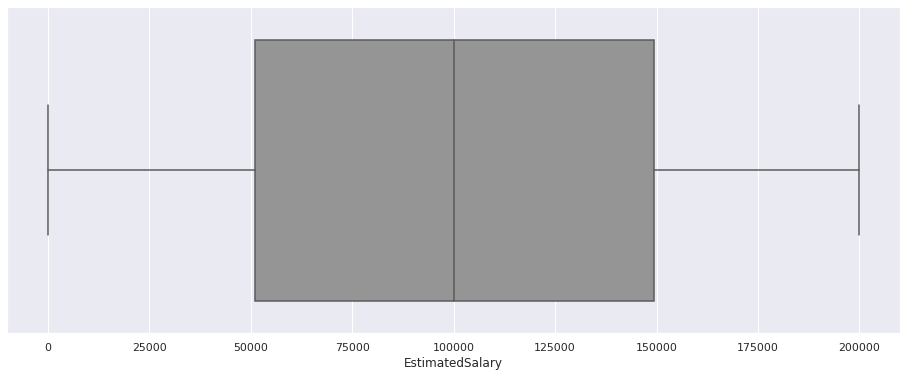

In [ ]:
sns.boxplot(data=df, x='EstimatedSalary', palette='Greys');

# ok

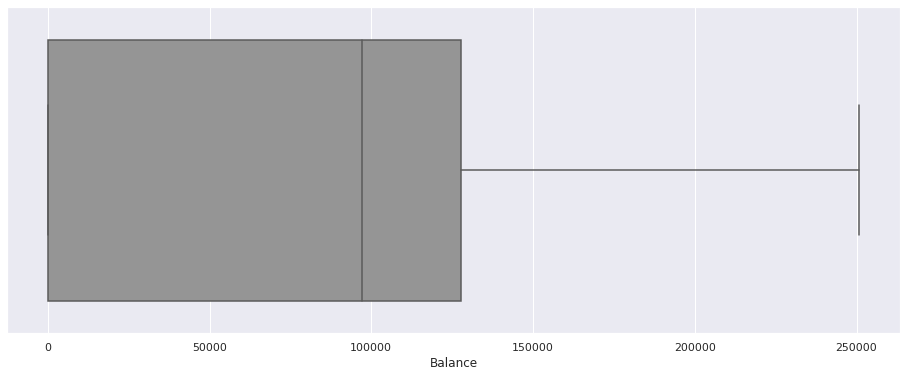

In [ ]:
sns.boxplot(data=df, x='Balance', palette='Greys');

# temos alguns balanços próximos a 250mil, mas não chegam a configurar outliers, vamos ver quais clientes tem esse balanço.

In [ ]:
df.sort_values('Balance', ascending=False)

# algo interessante é que os 3 clientes com os maiores balanços entraram em churn.
# mas não são dados discrepantes

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2092,2093,15757408,Lo,655,Spain,Male,38,3,250898.09,3,0,1,81054.00,1
3280,3281,15715622,To Rot,583,France,Female,57,3,238387.56,1,0,1,147964.99,1
8733,8734,15714241,Haddon,749,Spain,Male,42,9,222267.63,1,0,0,101108.85,1
3588,3589,15571958,McIntosh,489,Spain,Male,40,3,221532.80,1,1,0,171867.08,0
6717,6718,15586674,Shaw,663,Spain,Female,58,5,216109.88,1,0,1,74176.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136,7137,15689781,Ts'ai,826,France,Female,49,0,0.00,1,0,0,178709.98,1
829,830,15639788,Yuan,577,France,Female,39,10,0.00,2,1,0,10553.31,0
7139,7140,15805212,Black,806,France,Female,67,1,0.00,2,0,1,103945.58,0
4290,4291,15598884,Kent,650,Spain,Female,23,5,0.00,1,1,1,180622.43,0


É possível que clientes com maiores balanços tenham deixado mais o banco, isso será verificado na EDA

# Análise exploratória

Aqui eu procuro ver como as diferentes variáveis se relaciona com a classe que quero prever, procurando os atributos que trazem maiores ganhos de informação e podem ser usados no modelo

Vamos olhar a distribuição de algumas colunas com muitos números por ambas as classes e notar se existe alguma diferença aparente:

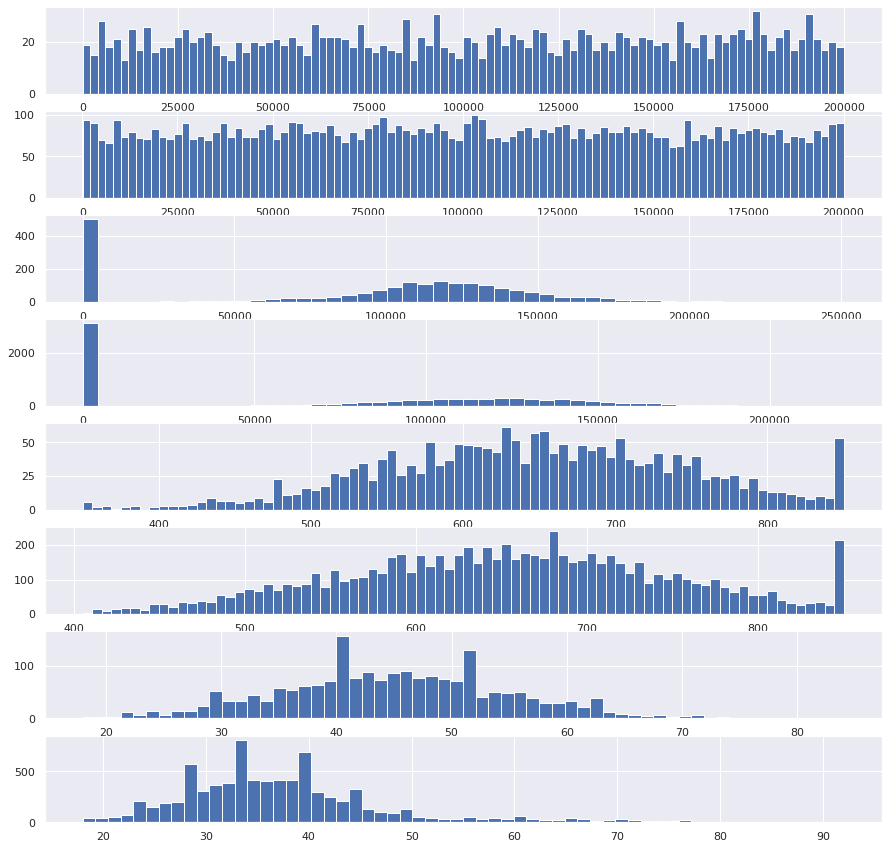

In [ ]:
fig, listagrafico = plt.subplots(nrows=8, ncols=1, figsize=(15,15))

listagrafico[0].hist(df.EstimatedSalary[df.Exited==1], bins=100);
listagrafico[1].hist(df.EstimatedSalary[df.Exited==0], bins=100);

listagrafico[2].hist(df.Balance[df.Exited==1], bins=50);
listagrafico[3].hist(df.Balance[df.Exited==0], bins=50);

listagrafico[4].hist(df.CreditScore[df.Exited==1], bins=80);
listagrafico[5].hist(df.CreditScore[df.Exited==0], bins=80);

# aqui vemos que quem deixou o banco e quem ficou tem as faixas salariais distribuídas similarmente.
# quem deixou o banco costuma ter um balanço parecido com quem ficou na distribuição.
# normalmente as pessoas que deixaram o banco tem "scores" mais baixos, a mediana e a distribuição dos scores na classe 1 é ligeiramente mais baixa.

# portanto, o score parece ter trazido algum ganho de informção interessante

listagrafico[6].hist(df.Age[df.Exited==1], bins=60);
listagrafico[7].hist(df.Age[df.Exited==0], bins=60);

# já na parte da idade vemos que a distribuição da idade entre os clientes que saíram é deslocada para as idades maiores, oque é um claro indicativo que clients mais velhos cancelaram mais seus registros.

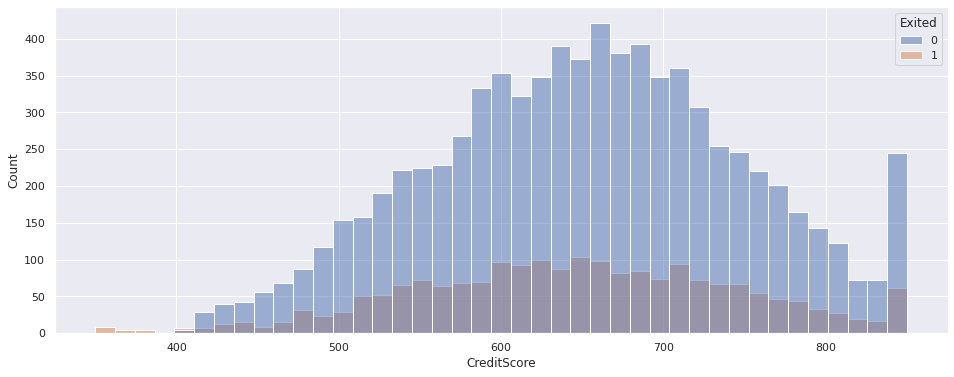

In [ ]:
sns.histplot(data=df, x='CreditScore', hue='Exited');

- Score: ligeiramente mais baixo na classe "1". Além de ser mais homogeneamente distribuído

- Idade: mais alta na classe  "1"

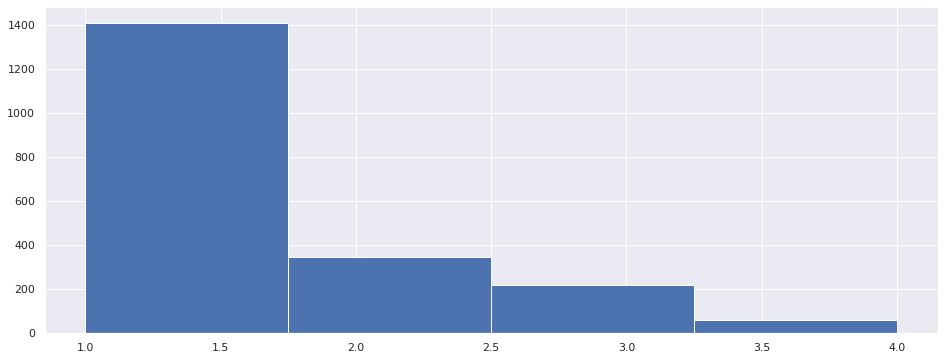

In [ ]:
plt.hist(df.NumOfProducts[df.Exited==1], bins=4);

A maioria das pessoas que saíram tinham só um produto adquirido.

Mas afinal, a maioria das pessoas tem quantos produtos?

In [ ]:
df['NumOfProducts'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64

A maioria dos clientes tem 1 produto, a mediana sendo 1 em 10.000 linhas da essa informação

Portanto, a maioria que saiu ter um produto não traz tanto ganho de informação

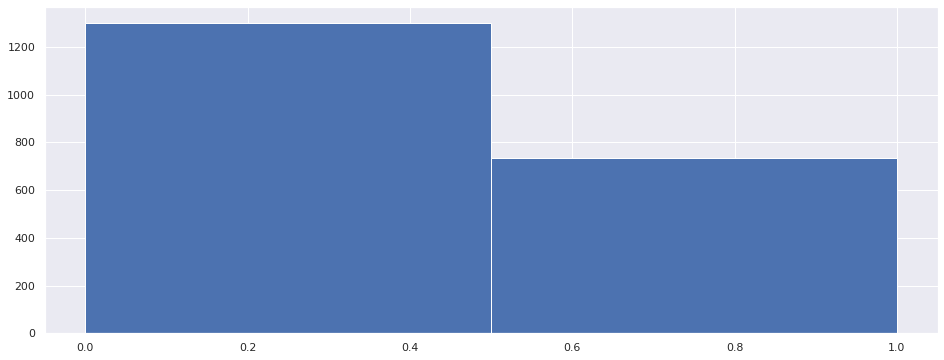

In [ ]:
plt.hist(df.IsActiveMember[df.Exited==1], bins=2);

# a maioria das pessoas que saiu não eram membros ativos, mas afinal, como é a divisão entre ativos e inativos?

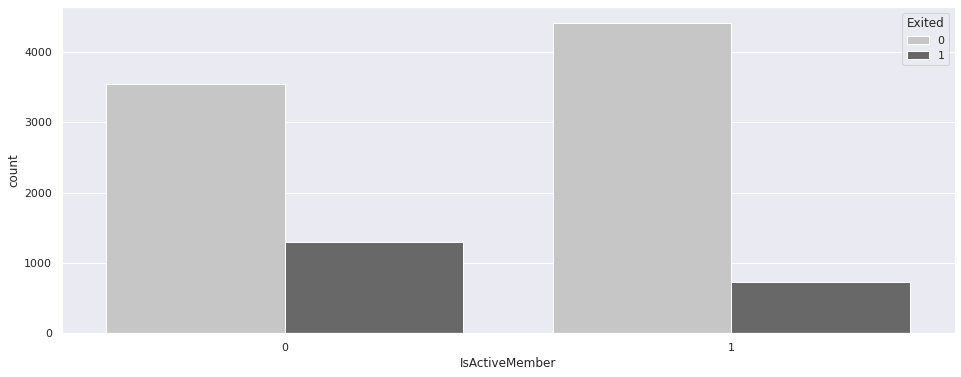

In [ ]:
sns.countplot(data=df, x='IsActiveMember', hue='Exited', palette='Greys');

Mesmo a maior parte da base sendo ativa a porção que saiu mais está na parte inativa.

A divisão de ativos e inativos é similar, portanto o membro ser inativo pode ser um indicador de churn.

Churn at France: 810
Churn at Spain: 413
Churn at Germany: 814


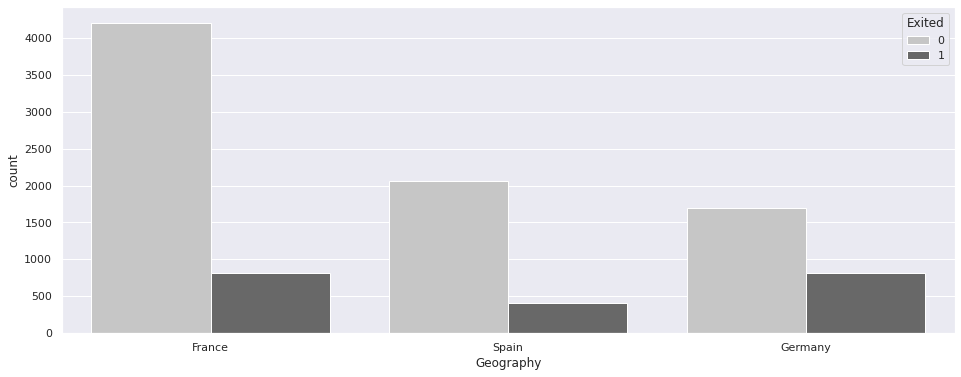

In [ ]:
sns.countplot(data=df, x='Geography', hue='Exited', palette='Greys');

# temos pessoas que saíram de todos os 3 locais, mas o local com mais vasão percentual foi a Alemanha.

paises = ['France', 'Spain', 'Germany']

for i in paises:
    dfl = df.loc[(df['Geography'] == i) & (df['Exited']== 1)]
    x = dfl['Exited'].sum()
    y = df['Exited'].sum()
    print(f'Churn at {i}: {x}')

Com um pequeno loop for conseguimos plotar uma contagem junto ao gráfico dos clientes que saíram por país.

O número de clientes perdidos na Alemanha foi o maior, e é o local com menos clientes em geral, portanto o cliente ser alemão nessa base é um indicativo de churn

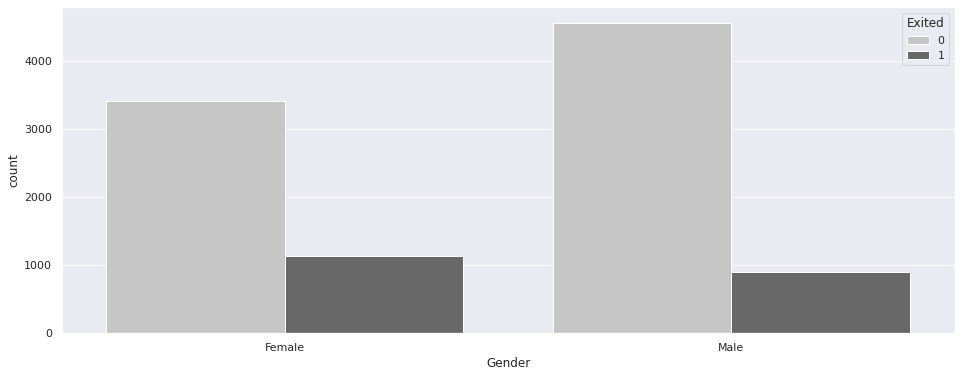

In [ ]:
sns.countplot(data=df, x='Gender', hue='Exited', palette='Greys');

Mulheres saíram mais percentualmente, mas não em um nível que possa deixar de ser coincidência

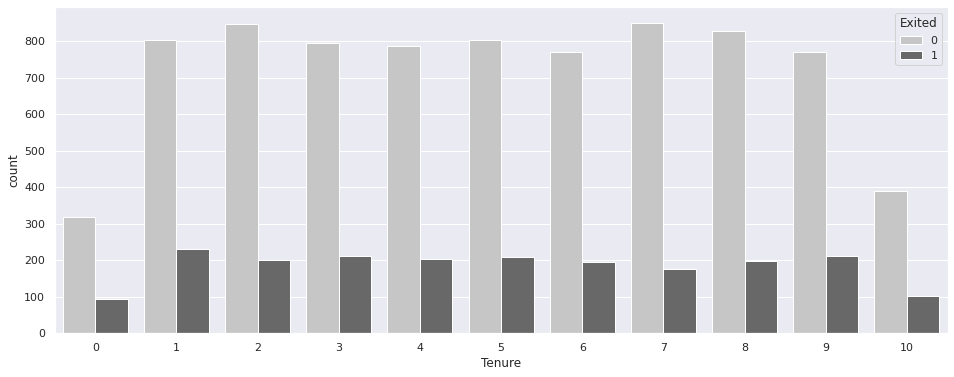

In [ ]:
sns.countplot(data=df, x='Tenure', hue='Exited', palette='Greys');

Temos clientes saindo tanto em faixas com conta há bastante tempo e em faixas com contas recentes, portanto isso parece ser inconclusivo isoladamente com o churn

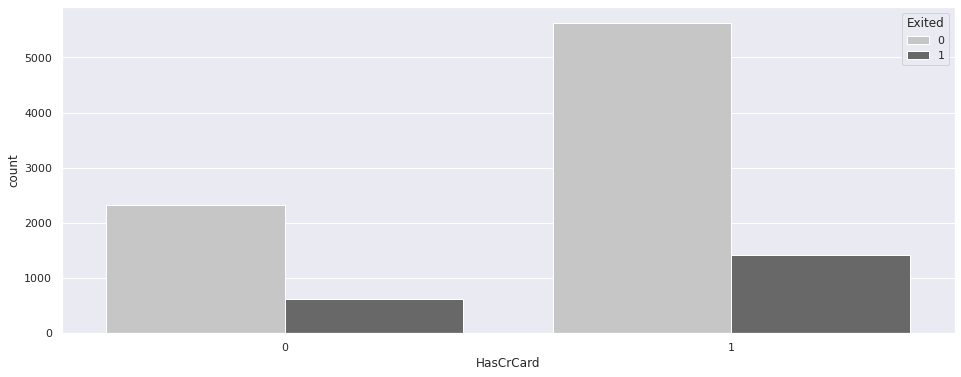

In [ ]:
sns.countplot(data=df, x='HasCrCard', hue='Exited', palette='Greys');

Mesmo que clientes com cartão tenham deixado mais o banco, a quantia de clientes com cartão é o dobro da de quantia sem cartão, portanto isso parece não trazer ganho de informação isoladamente

# Conclusões da etapa exploratória:

- **Pessoas mais velhas cancelaram mais suas contas que pessoas mais novas.**

- **Clientes Inativos a mais de um ano cancelaram mais suas contas.**

- **Clientes com score mais baixo cancelaram mais suas contas.**

- **A Alemanha teve o pior nível de churn.**

- **A base está bem desbalanceada, necessário se ater a isso para medir correlação apenas após o balanceamento, e jogar os dados no modelo depois.**

# Escalonando valores antes de dividir

Em modelos de ML é melhor que as variáveis numéricas estejam escalonadas, isso facilita o aprendizado dos modelos, portanto é isso que faço nessa seção

In [ ]:
escala = StandardScaler()

df['CreditScore'] = escala.fit_transform(df['CreditScore'].values.reshape(-1, 1))
df['Age'] = escala.fit_transform(df['Age'].values.reshape(-1, 1))
df['EstimatedSalary'] = escala.fit_transform(df['EstimatedSalary'].values.reshape(-1, 1))
df['NumOfProducts'] = escala.fit_transform(df['NumOfProducts'].values.reshape(-1, 1))
df['Balance'] = escala.fit_transform(df['Balance'].values.reshape(-1, 1))
df['Tenure'] = escala.fit_transform(df['Tenure'].values.reshape(-1, 1))

As variáveis que devem ser escalonadas são as numéricas:

- 'CreditScore'
- 'Age'
- 'EstimatedSalary'
- 'NumOfProducts'
- 'Balance'
- 'Tenure'

In [ ]:
df.head() #escalonado!

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1
1,2,15647311,Hill,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0
2,3,15619304,Onio,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1
3,4,15701354,Boni,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0
4,5,15737888,Mitchell,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0


# Definir Treino/Teste

Separar as variáveis que serão usadas para treino e a variável que será prevista

 - X = Coluna 3 até 13 do DF onde temos os atributos previsores.

- Y = O classificador como cliente em Churn, ou não.

In [ ]:
x = df.iloc[:, 3:13].values
y = df.iloc[:, 13].values

In [ ]:
x # ok, tudo certo

array([[-0.3262214220367463, 'France', 'Female', ..., 1, 1,
        0.021886493995386117],
       [-0.4400359548576657, 'Spain', 'Female', ..., 0, 1,
        0.21653375188734025],
       [-1.536794180222889, 'France', 'Female', ..., 1, 0,
        0.24068690006348814],
       ...,
       [0.6049883919525944, 'France', 'Female', ..., 0, 1,
        -1.0086430751933764],
       [1.2568352617451328, 'Germany', 'Male', ..., 1, 0,
        -0.12523071253853688],
       [1.4637707759649863, 'France', 'Female', ..., 1, 0,
        -1.07636975538291]], dtype=object)

In [ ]:
y # ok, tudo certo

array([1, 0, 1, ..., 1, 1, 0])

# Jogar Categóricos para numéricos

Algorítimos de ML não sabem trabalhar com string's, portanto é necessário assumir um "index" para cada valor categórico no DataFrame

In [ ]:
encodarpais = LabelEncoder()
encodargenero = LabelEncoder()
x[:, 1] = encodarpais.fit_transform(x[:, 1])  # transformar Páis em número
x[:, 2] = encodargenero.fit_transform(x[:, 2]) # transformar gênero em número

In [ ]:
hotdf = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1, 2])], remainder='passthrough')

# adicionar linhas para registrar strings "encodadas", evitando erros no modelo

In [ ]:
x = hotdf.fit_transform(x) # onehotencoder aqui

In [ ]:
x # pronto! tudo em escala, strings em números, e sem strings crescentes

array([[1.0, 0.0, 0.0, ..., 1, 1, 0.021886493995386117],
       [0.0, 0.0, 1.0, ..., 0, 1, 0.21653375188734025],
       [1.0, 0.0, 0.0, ..., 1, 0, 0.24068690006348814],
       ...,
       [1.0, 0.0, 0.0, ..., 0, 1, -1.0086430751933764],
       [0.0, 1.0, 0.0, ..., 1, 0, -0.12523071253853688],
       [1.0, 0.0, 0.0, ..., 1, 0, -1.07636975538291]], dtype=object)

# Separar Treino & Teste

obs: e também balancear a base antes de ver a correlação de variáveis

In [ ]:
xtreino, xteste, ytreino, yteste = train_test_split(x, y, stratify=y, shuffle=True)

In [ ]:
x.shape, y.shape

((10000, 13), (10000,))

In [ ]:
# agora vamos balancear com o RandomUnderSampling

rn = RandomUnderSampler()
x_random, y_random = rn.fit_resample(x, y)

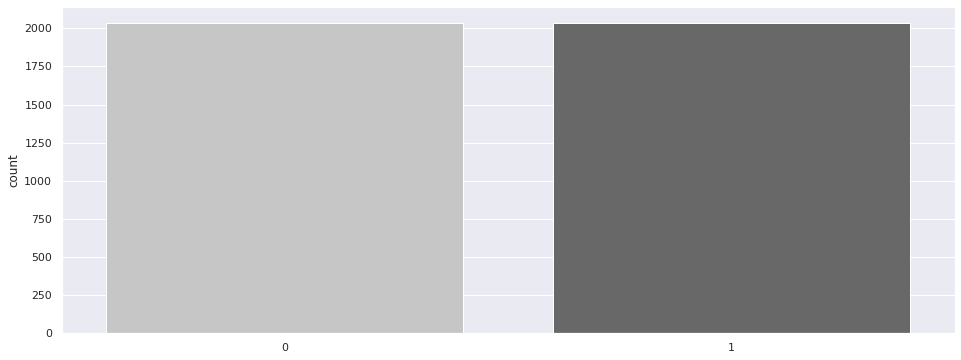

In [ ]:
sns.countplot(y_random, palette='Greys');

# ok agora as classes estão equilibradas

# Correlação

Com o balanceamento entre variáveis podemos plotar a matriz de correlação com mais exatidão

Ok, agora que o balanceamento está correto a correlação pode ficar mais precisa, e posso tirar atributos altamente correlacionados para não enviesar meu modelo

In [ ]:
colunas = ['Franca', 'Alemanha', 'Espanha', 'Mulher1', 'Homem1', 'Score', 'Idade', 'Tenure', 'Balance', 'NdeProd', 'Temcartao', 'Ativo', 'Salário']

dataframe_correlacao_equilibrado = pd.DataFrame(x_random, columns=colunas)

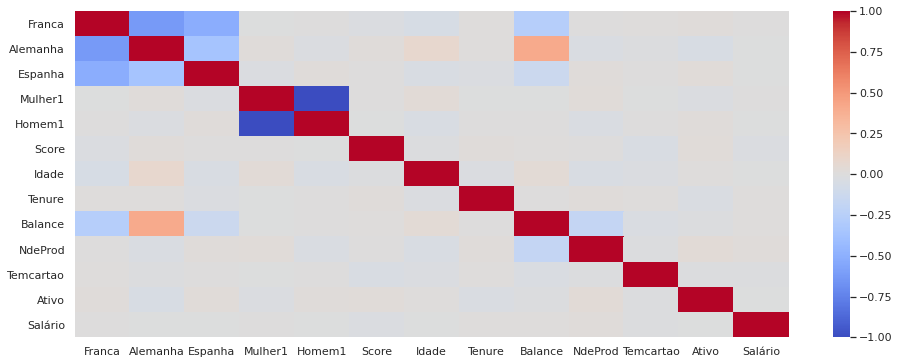

In [ ]:
# dataframe_correlacao_equilibrado.astype('float64').corr()
# pouco visual, vamos plotar a correlação no seaborn

dataframe_correlacao_equilibrado = dataframe_correlacao_equilibrado.astype('float64')
correlacao = dataframe_correlacao_equilibrado.corr()


sns.heatmap(correlacao, cmap="coolwarm");

# não há correlação suficiente para tirar alguma variável do modelo

# Salvar treino & teste normalizados como arquivo.pickle

In [ ]:
with open('churn.pkl', mode = 'wb') as f:
  pkl.dump([xtreino, ytreino, xteste, yteste], f)

In [ ]:
with open('churn.pkl', 'rb') as f:
    xtreino, ytreino, xteste, yteste = pkl.load(f)

# Observações: IA'S

- **23/07/2021: Irei rodar os algorítimos com as variáveis equilibradas e sem as variáveis equilibradas, para ver comparativamente** 

- **26/07/2021: As técnicas de equilíbrio ou geraram overfitting, ou diminuíam o acerto devido à diminuição de exemplos de treino para a IA. Optei por usar as variáveis sem equilíbrio.**

- **mais adiante irei fazer o tunning e também juntar o treino e o teste para validação cruzada**

# Arvore de Decisão

In [ ]:
arvore = DecisionTreeClassifier(criterion='entropy')
arvore.fit(xtreino, ytreino)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
previsoes_arvore = arvore.predict(xteste)

In [ ]:
accuracy_score(yteste, previsoes_arvore) 

# 79%
# obs: no passado o acerto inicial havia cedo de 73%, quando a base estava desequilibrada e não escalonada em padrões corretos, fiquei feliz com o avanço!

0.7968

In [ ]:
matriz = classification_report(yteste, previsoes_arvore)
print(matriz)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1991
           1       0.50      0.51      0.51       509

    accuracy                           0.80      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.80      0.80      0.80      2500



O algorítimo não teve um bom acerto na classe "1" que foi a a classe que deixou o banco.

Isso será corrigido na parte de tunning dos parâmetros, onde espero melhorar essa taxa de acerto

Abaixo temos um gráfico que elenca quais caraterísticas do DataFrame trazem mais ganho de informação pelos critérios da árvore

In [ ]:
atributos = arvore.feature_importances_

Atributo 0 : Franca
Atributo 1 : Alemanha
Atributo 2 : Espanha
Atributo 3 : Mulher1
Atributo 4 : Homem1
Atributo 5 : Score
Atributo 6 : Idade
Atributo 7 : Tenure
Atributo 8 : Balance
Atributo 9 : NdeProd
Atributo 10 : Temcartao
Atributo 11 : Ativo
Atributo 12 : Salário


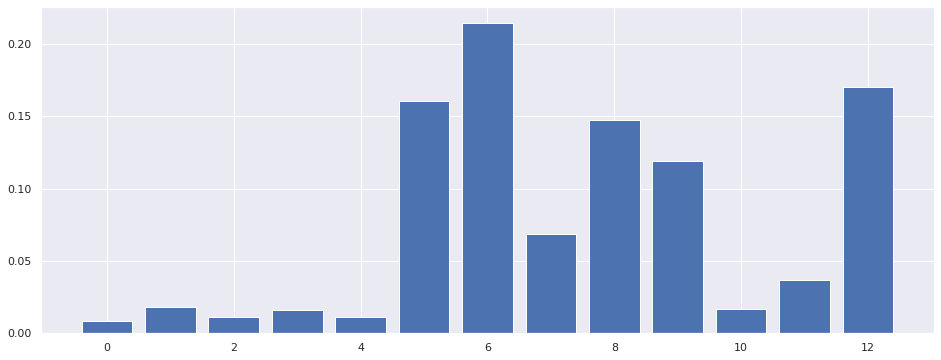

In [ ]:
contador = 0
previsores = ['Franca', 'Alemanha', 'Espanha', 'Mulher1', 'Homem1', 'Score', 'Idade', 'Tenure', 'Balance', 'NdeProd', 'Temcartao', 'Ativo', 'Salário']


for i in previsores:
  print(f'Atributo {contador} : {i}')
  contador += 1

plt.bar([x for x in range (len(previsores))], atributos);

Abaixo vou rodar a árvore de decisão e imprimir a imagem

obs: essa parte está comentada, pois, a imagem demora bastante para baixar, caso queria basta tirar os comentários e baixar a imagem

In [ ]:
# previsores = ['Franca', 'Alemanha', 'Espanha', 'Mulher1', 'Homem1', 'Score', 'Idade', 'Tenure', 'Balance', 'NdeProd', 'Temcartao', 'Ativo', 'Salário']
# plt.figure(figsize=(350,350))
# tree.plot_tree(arvore, fontsize=40, filled=True, feature_names=previsores)
# plt.show()

# SVM

In [ ]:
xtreino

array([[0.0, 0.0, 1.0, ..., 1, 1, 1.4371619641472757],
       [0.0, 0.0, 1.0, ..., 0, 1, 0.9192884816577434],
       [0.0, 0.0, 1.0, ..., 1, 1, -0.15547088043337287],
       ...,
       [1.0, 0.0, 0.0, ..., 1, 1, 0.08896630335636603],
       [0.0, 0.0, 1.0, ..., 1, 0, 0.4373431092141197],
       [0.0, 1.0, 0.0, ..., 1, 0, 1.694366673970588]], dtype=object)

In [ ]:
SVM = SVC(kernel='poly', random_state=1, C=2.0)
SVM.fit(xtreino, ytreino)
previsoes_svm = SVM.predict(xteste)

In [ ]:
accuracy_score(yteste, previsoes_svm)
# 85%

0.8548

In [ ]:
matriz = classification_report(yteste, previsoes_svm)
print(matriz)

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1991
           1       0.76      0.42      0.54       509

    accuracy                           0.85      2500
   macro avg       0.81      0.69      0.73      2500
weighted avg       0.85      0.85      0.84      2500



22/07: Resultado Parecido com a árvore, talvez seja problema da base ser desbalanceada na hora da validação cruzada e do tunning isso será corrigido

24/07: melhoras significativas na base por escalonamento de parâmetros, agora o SVM acertou 5,65% a mais que a árvore!

O modelo tem uma excelente precisão com a classe "0", porém com a classe 1 ainda temos um acerto muito baixo

# Rede neural

In [ ]:
neural = MLPClassifier(max_iter=1500, verbose=False, tol=0.000100, solver='adam', activation='relu', hidden_layer_sizes= (5,5))
neural.fit(xtreino, ytreino)
previsoes_neural = neural.predict(xteste)

In [ ]:
accuracy_score(yteste, previsoes_neural)

0.8584

In [ ]:
matriz = classification_report(yteste, previsoes_neural)
print(matriz)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1991
           1       0.72      0.50      0.59       509

    accuracy                           0.86      2500
   macro avg       0.80      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



85,68%

Anteriormente também havia tido um acerto baixo aqui, o correto escalonamento dos dados melhorou bastante a precisão

Porém, o acerto ainda deixa a desejar com a classe "1"

# Tunar os parâmetros

Nessa sessão os parâmetros são testados em diferentes combinações na busca de melhorar o acerto do algorítimo

Além disso, os algorítimos também cruzam as partes da base entre elas tentando não pegar sempre o mesmo local do dataset para treino e para teste, evitando vieses

Juntando o treino e o teste para validação cruzada

In [ ]:
xtreino.shape,ytreino.shape, xteste.shape, yteste.shape

((7500, 13), (7500,), (2500, 13), (2500,))

In [ ]:
# Primeiro vamos fazer treino e teste em GRID, vamos concatenar os treinos e testes para isso

x = np.concatenate((xtreino, xteste), axis=0)
y = np.concatenate((ytreino, yteste), axis=0)

In [ ]:
x # ok, x está certinho.

array([[0.0, 0.0, 1.0, ..., 1, 1, 1.4371619641472757],
       [0.0, 0.0, 1.0, ..., 0, 1, 0.9192884816577434],
       [0.0, 0.0, 1.0, ..., 1, 1, -0.15547088043337287],
       ...,
       [0.0, 0.0, 1.0, ..., 1, 0, -1.3508749559598858],
       [0.0, 0.0, 1.0, ..., 1, 1, 1.3797539170132185],
       [0.0, 0.0, 1.0, ..., 1, 0, -1.2667172350550673]], dtype=object)

In [ ]:
y # y também.

array([0, 0, 0, ..., 0, 0, 0])

Com o x e o y concatenados podemos fazer o processo de validação cruzada e teste dos melhores parâmetros

Isso é feito definindo uma lista com os parâmetros para serem testados e colocando essa lista como "param_grid"nos parâmetros dos algorítimos.

**Tuning Decision Tree**

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random'],
             'min_samples_split':[1, 2, 5, 10, 15, 20],
             'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100]}

In [ ]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(x, y);
melhor_parametro_arvore = grid_search.best_params_
melhor_score_arvore = grid_search.best_score_
print(melhor_parametro_arvore)
print(melhor_score_arvore)

# no primeiro resultado ele definiu o "min_samples_leaf" como 10
# como 10 era o maior fez sentido aumentar o range de teste

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1


/usr/local/lib/python3.7/dis

{'criterion': 'gini', 'min_samples_leaf': 30, 'min_samples_split': 2, 'splitter': 'best'}
0.858


85,68%, contra 80,32%, melhorou bastante!

Melhores parâmetros: 
{'criterion': 'gini', 'min_samples_leaf': 30, 'min_samples_split': 2, 'splitter': 'best'}

**Tuning SVM**

In [ ]:
parametros_svm = {'kernel': ['rbf', 'linear', 'sigmoid'],
             'C': [1.0, 2.0]}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros_svm)
grid_search.fit(x, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 2.0],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
melhor_parametro_svm = grid_search.best_params_
melhor_score_svm = grid_search.best_score_

In [ ]:
print(melhor_parametro_svm)
print(melhor_score_svm)

{'C': 1.0, 'kernel': 'rbf'}
0.8586


Melhores: {'C': 1.0, 'kernel': 'rbf'}

85,99% contra 85,05%. Não houve muita melhora tunando esses parâmetros

**Tunning Rede Neural**

In [ ]:
parametros_rede_neural = {'activation':['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'], 
              'batch_size': [10, 56]}

grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros_rede_neural)
grid_search.fit(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [ ]:
melhor_parametro_rede = grid_search.best_params_
melhor_score_rede = grid_search.best_score_
print(melhor_parametro_rede)
print(melhor_score_rede)

{'activation': 'relu', 'batch_size': 56, 'solver': 'sgd'}
0.8607000000000001


**Melhores: {'activation': 'relu', 'batch_size': 56, 'solver': 'sgd'}**

**86,11% contra 85,68% sem tunning**

# Validação cruzada

Aqui são realizados testes nos modelos e os resultados são guardados, de modo a verificar se existem diferenças estatísticas significativas entre os resultados deles

In [ ]:
testes_arvore = []
testes_svm = []
testes_rede_neural = []

for i in range(10): # 30 seria o idel porém as rodagens demoradas são interompidas pelo colab
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    arvore = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15, min_samples_split=20, splitter='random')
    scores = cross_val_score(arvore, x, y, cv=kfold)
    testes_arvore.append(scores.mean())
    
    svm = SVC(C=2.0, kernel='rbf')
    scores = cross_val_score(svm, x, y, cv=kfold)
    testes_svm.append(scores.mean())
    
    rede = MLPClassifier(activation='logistic', batch_size=10, solver='adam')
    scores = cross_val_score(rede, x, y, cv=kfold)
    testes_rede_neural.append(scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

Agora vamos colocar as listas das médias dos resultados em um dicionário que pode ser convertido para um DataFrame para uma melhor análise da distribuição dos resultados.

In [ ]:
dfresultados = pd.DataFrame({'SVM':testes_svm, 'Arvore':testes_arvore, 'Rede_Neural':testes_rede_neural})

dfresultados.describe()

# o melhor desvio padrão é da rede neural
# a melhor média e mediana tambem é da rede neural

,SVM,Arvore,Rede_Neural
count,10.000000,10.000000,10.000000
mean,0.858210,0.850420,0.858890
std,0.001018,0.002729,0.001510
min,0.856800,0.845600,0.855500
25%,0.857300,0.849100,0.858550
50%,0.858150,0.850150,0.859250
75%,0.859075,0.852675,0.859925
max,0.859600,0.854000,0.860400


# Testes de Normalidade

Para verificar se os modelos têm resultados próximos, é feito uma validação estatística das distribuições dos resultados, porém esse teste só funciona quando o intervalo de resultados é uma distribuição normal, aqui, antes dos testes comparativos, verificamos se as distribuições de resultados são normais

In [ ]:
# checar se os resultados convergem para uma distribuição normal

alpha = 0.05

shapiro(testes_svm), shapiro(testes_arvore), shapiro(testes_rede_neural)

# todos os resultados estão em distribuições normais!

((0.9207500219345093, 0.3632529675960541),
 (0.9428709745407104, 0.5853793025016785),
 (0.8656802773475647, 0.08899353444576263))

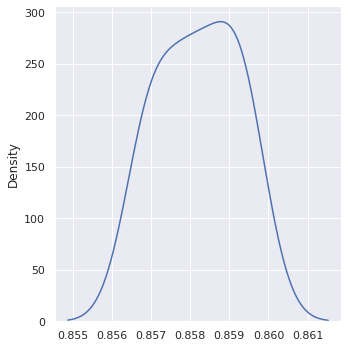

In [ ]:
sns.displot(data=testes_svm, kind='kde'); 

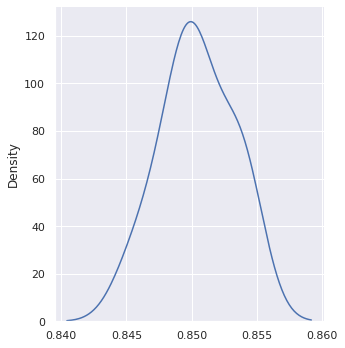

In [ ]:
sns.displot(data=testes_arvore, kind='kde');

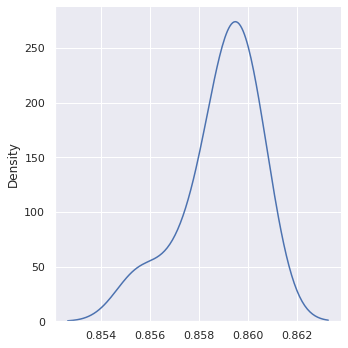

In [ ]:
sns.displot(data=testes_rede_neural, kind='kde');

# Testes de Hipótese

Aqui são testados os resultados para ver se há diferença suficientemente grande entre eles para dizer que um algorítimo é melhor que outro

In [ ]:
p = f_oneway(testes_svm, testes_arvore, testes_rede_neural)

# resultado abaixo do alpha te da sinal de que os testes são suficientemente diferentes entre eles
 
print(p) # p é bem menor que o alpha, portanto vale a pena verificar qual o melhor algorítimo

F_onewayResult(statistic=61.728977847512404, pvalue=8.478249659328221e-11)


In [ ]:
resultadosfinais = {'acurácia':np.concatenate([testes_svm, testes_arvore, testes_rede_neural]),
                    'ia': ['svm', 'svm', 'svm', 'svm', 'svm', 'svm', 'svm', 'svm', 'svm', 'svm',
                    'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 'arvore', 
                    'neural', 'neural', 'neural', 'neural', 'neural', 'neural', 'neural', 'neural', 'neural', 'neural']}

In [ ]:
df_resultados_finais = pd.DataFrame(resultadosfinais)

In [ ]:
df_resultados_finais

,acurácia,ia
0,0.8579,svm
1,0.8596,svm
2,0.8570,svm
3,0.8582,svm
4,0.8571,svm
5,0.8581,svm
6,0.8590,svm
7,0.8593,svm
8,0.8591,svm
9,0.8568,svm


In [ ]:
comparar = MultiComparison(resultadosfinais['acurácia'], resultadosfinais['ia'])
tabela_estatistica  = comparar.tukeyhsd()
print(tabela_estatistica)

# rejeitamos a hipótese nula para todos menos para a comparação da rede neural com o SVM, entre eles o desempenho é similar.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
arvore neural   0.0085 0.001  0.0064 0.0106   True
arvore    svm   0.0078 0.001  0.0057 0.0099   True
neural    svm  -0.0007 0.692 -0.0028 0.0014  False
--------------------------------------------------


In [ ]:
dfresultados.mean()

SVM            0.85821
Arvore         0.85042
Rede_Neural    0.85889
dtype: float64

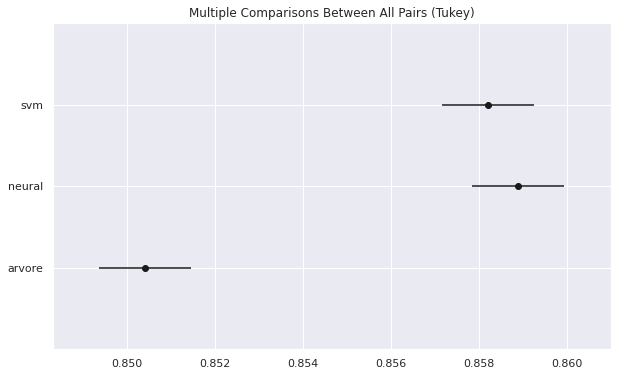

In [ ]:
tabela_estatistica.plot_simultaneous();

# Salvar os parâmetros

In [ ]:
classificadores_rede = MLPClassifier(activation='logistic', batch_size=10, solver='adam')
classificadores_rede.fit(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(activation='logistic', alpha=0.0001, batch_size=10, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [91]:
classificadores_svm = SVC(C=2.0, kernel='rbf')
classificadores_svm.fit(x, y)

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
classificadores_arvore = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15, min_samples_split=20, splitter='random')
classificadores_arvore.fit(x, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [93]:
pkl.dump(classificadores_rede, open('rede.sav', 'wb'))
pkl.dump(classificadores_svm, open('svm.sav', 'wb'))
pkl.dump(classificadores_arvore, open('arvore.sav', 'wb'))